# Question 2:  BERT model fine tunning

**BERT** is state of art model in lots of LLM tasks.
Model:
* [ParsBert](https://huggingface.co/HooshvareLab/bert-base-parsbert-uncased)

Dataset:
* [FarsTails](https://github.com/dml-qom/FarsTail)

Papers used for this project:
* [What Would Elsa Do? Freezing Layers During Transformer Fine-Tuning](https://arxiv.org/abs/1911.03090).
* [Are Sixteen Heads Really Better than One?](https://arxiv.org/abs/1905.10650).



## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import librosa
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import requests
import zipfile
import io

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
import re
import unicodedata


from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
from transformers import BertModel
import torch


## 2-1-1. Preprocess

In this exercise, we will get to know the BERT transformer model and we will analyze and analyze it. In this regard, various experiments have been designed on the task of inferring natural language, which we will discuss below. Use the ParsBERT model to perform tasks in all stages.


Use the FarsTail dataset for all the mentioned tasks. Provide statistical information including the distribution of classes and length of sentences (based on the number of tokens) of this dataset and describe your preprocessing methods.

### 2-1-1-1. Download and load dataset

In [2]:
url = 'https://github.com/dml-qom/FarsTail/archive/refs/heads/master.zip'

request = requests.get(url, allow_redirects=True)

zip_file = zipfile.ZipFile(io.BytesIO(request.content))

target_directory = '/content/FarsTail_dataset'

zip_file.extractall(target_directory)

print(f'The FarsTails dataset has been successfully downloaded and extracted to {target_directory}.')


The FarsTails dataset has been successfully downloaded and extracted to /content/FarsTail_dataset.


### 2-1-1-2. Creating Train, Test, Validation DF

In [3]:
train_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Train-word.csv', sep='\t')
val_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Val-word.csv', sep='\t')
test_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Test-word.csv', sep='\t')

In [ ]:
train_data.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [ ]:
val_data.head()

,premise,hypothesis,label
0,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,کتاب مگیستی (المجسطی) از آثار بطلمیوس است و از...,e
1,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,المجسطی (مگیستی)، یکی از کتاب های هرون از مکتب...,c
2,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,ترجمه المجسطی، پایه تهیه جداول نجومی گردید که ...,n
3,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,کتاب کلمات قصار یا فصول، اثر بقراط است.,e
4,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,جالینوس، نویسنده کتاب کلمات قصار بوده است.,c


## 2-1-1-3. Statistical analysis on dataset

* Showing distribution of classes
* Showing length of sentences
* Preprocessing the Cleaned Text

#### Distribution of different classes

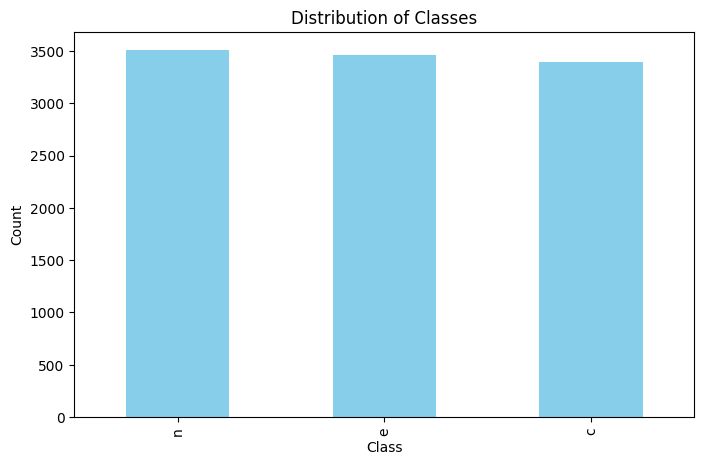

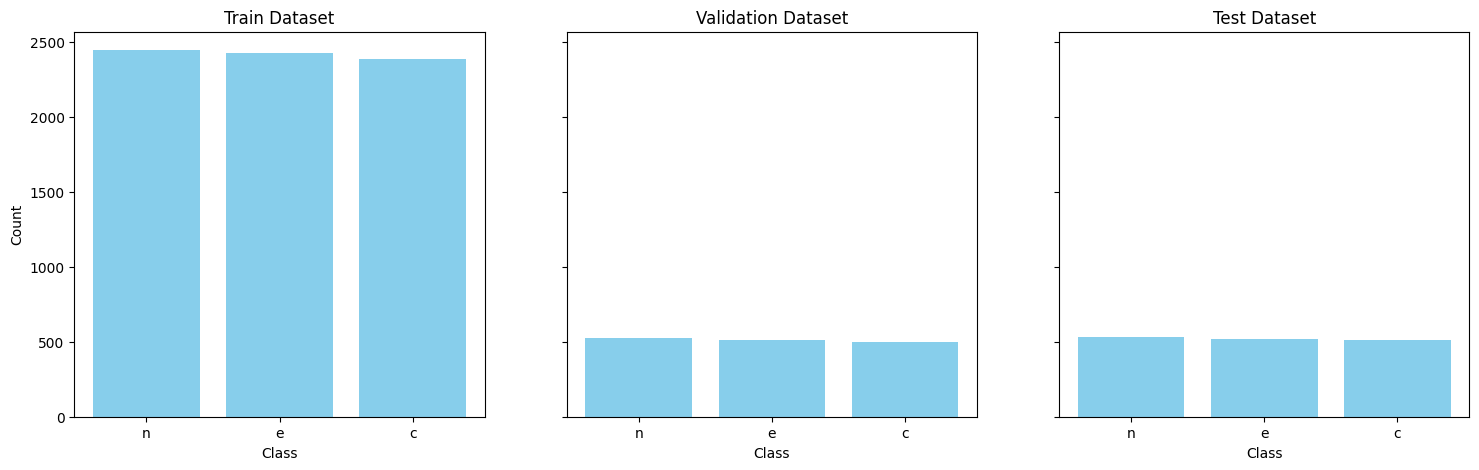


Training Data Class Distribution:
n    2448
e    2429
c    2389
Name: label, dtype: int64

Validation Data Class Distribution:
n    523
e    515
c    499
Name: label, dtype: int64

Test Data Class Distribution:
n    535
e    519
c    510
Name: label, dtype: int64


In [ ]:
all_data = pd.concat([train_data, val_data, test_data])
class_distribution = all_data['label'].value_counts()
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Train dataset
train_distribution = train_data['label'].value_counts()
axes[0].bar(train_distribution.index, train_distribution, color='skyblue')
axes[0].set_title('Train Dataset')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')


# Validation dataset
val_distribution = val_data['label'].value_counts()
axes[1].bar(val_distribution.index, val_distribution, color='skyblue')
axes[1].set_title('Validation Dataset')
axes[1].set_xlabel('Class')


# Test dataset
test_distribution = test_data['label'].value_counts()
axes[2].bar(test_distribution.index, test_distribution, color='skyblue')
axes[2].set_title('Test Dataset')
axes[2].set_xlabel('Class')

plt.show()

print("\nTraining Data Class Distribution:")
print(train_distribution)
print("\nValidation Data Class Distribution:")
print(val_distribution)
print("\nTest Data Class Distribution:")
print(test_distribution)


#### Sentence length

In [ ]:
# load model
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

In [ ]:
def get_sentence_length(data):
    return data['premise'].apply(lambda x: len(tokenizer.encode(x, max_length=512, truncation=True)))

In [ ]:
train_sentence_length = get_sentence_length(train_data)
train_sentence_length.describe()

count    7266.000000
mean       43.792458
std        17.085853
min        11.000000
25%        31.000000
50%        41.000000
75%        54.000000
max       136.000000
Name: premise, dtype: float64

In [ ]:
validation_sentence_length = get_sentence_length(val_data)
validation_sentence_length.describe()

count    1537.000000
mean       43.163305
std        16.824191
min        10.000000
25%        31.000000
50%        41.000000
75%        52.000000
max       107.000000
Name: premise, dtype: float64

In [ ]:
test_sentence_length = get_sentence_length(test_data)
test_sentence_length.describe()

count    1564.000000
mean       42.619565
std        17.148977
min        12.000000
25%        30.000000
50%        40.000000
75%        52.000000
max       128.000000
Name: premise, dtype: float64

Text(0.5, 0, 'Sentence Length')

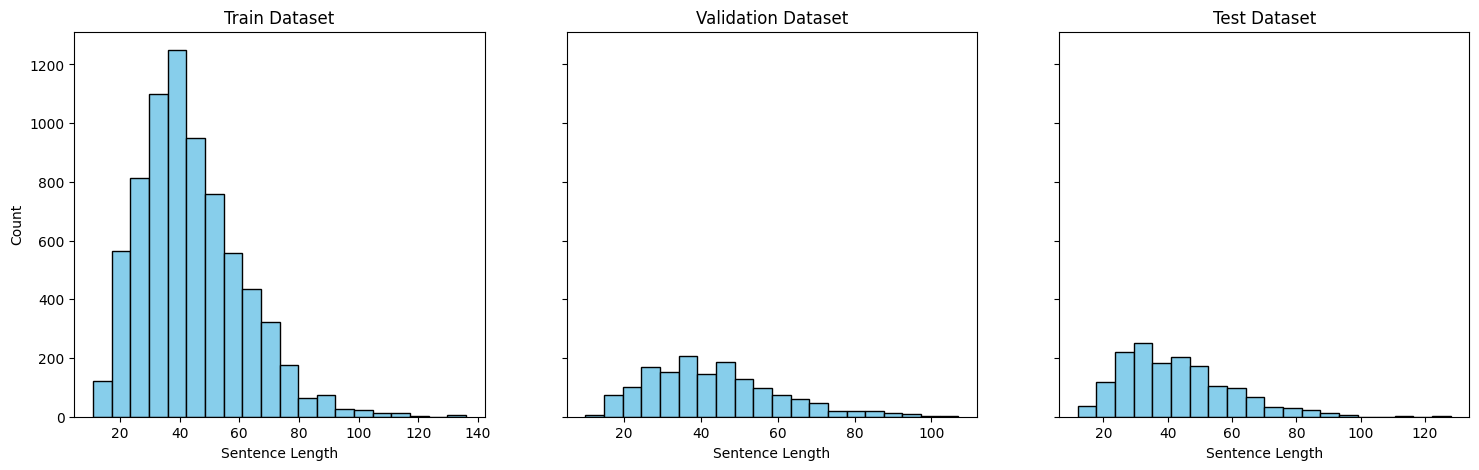

In [ ]:
# Plot the distribution of sentence lengths
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Train dataset
axes[0].hist(train_sentence_length, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Train Dataset')
axes[0].set_xlabel('Sentence Length')
axes[0].set_ylabel('Count')

# Validation dataset
axes[1].hist(validation_sentence_length, bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Validation Dataset')
axes[1].set_xlabel('Sentence Length')

# Test dataset
axes[2].hist(test_sentence_length, bins=20, color='skyblue', edgecolor='black')
axes[2].set_title('Test Dataset')
axes[2].set_xlabel('Sentence Length')


#### Preprocessing the Cleaned Text

In this step we provide text ready for process using a function
here are steps:
* Remove Special Characters and Punctuation
* Convert Text to Lowercase
* Handle Unicode Characters
* Remove Tags, HTML, CSS and so on using regex
* Remove ASCII Unwanted

In [ ]:

def handle_unicode(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

def remove_ascii(text):
    unwanted_ascii = set('\x00\x08\x0b\x0c\x0e\x1f\x7f\xff')
    return ''.join(char for char in text if char not in unwanted_ascii)


def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'<style[^<]*</style>|<script[^<]*</script>', '', text)
    text = re.sub(r'([^@\s#\w]|_)+', '', text)
    return text

def clean_dataframe_column(df, text_column):
    df[text_column] = df[text_column].apply(handle_unicode)
    df[text_column] = df[text_column].apply(remove_ascii)
    df[text_column] = df[text_column].apply(clean_text)
    return df


def clean_dataframe(df, text_columns):
    for column in text_columns:
        df = clean_dataframe_column(df, column)
    return df

In [ ]:
premise_column = 'premise'
hypothesis_column = 'hypothesis'

cleaned_train_data = clean_dataframe(train_data, [premise_column, hypothesis_column])
cleaned_val_data = clean_dataframe(val_data, [premise_column, hypothesis_column])
cleaned_test_data = clean_dataframe(test_data, [premise_column, hypothesis_column])


In [ ]:
train_data

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر اندلس و شام نخستین راه...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی ۱ تلفیقی بودن ۲ بازنمای...,نقاشی های تزيینی و تندیس های بیکیفیت یکی از وی...,e
4,ویژگی های هنر عصر اموی ۱ تلفیقی بودن ۲ بازنمای...,با کیفیت بودن تندیس های دوره اموی یکی از ویژگی...,c
...,...,...,...
7261,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,تعداد فصول قانون اساسی ۱۴ و تعداد اصول ان ۱۷۷ است,e
7262,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,قانون اساسی دارای ۲۵ فصل و ۱۷۵ اصل می باشد,c
7263,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,در ۲۴ ابان ۵۸ کار تدوین قانون اساسی به پایان رسید,n
7264,محاصره اقتصادی پیامبر ص و یارانش که در سال هفت...,حضرت محمد ص و یارانش از ششمین سال بعثت تا هشتم...,c


In [ ]:
print(train_data[['premise', 'hypothesis']].iloc[0])

premise       اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...
hypothesis    نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...
Name: 0, dtype: object


## 2-1-2. Fine Tune

First, it is necessary to adjust the model completely on the desired data set. Report the results of fine-tuning the model on the test data in the form of 1F accuracy and confusion matrix, score. Also, draw the graphs of error and accuracy changes during training on the evaluation data set.

#### Tokenize

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
label_map = {'e': 0, 'c': 1, 'n': 2}
train_data['label'] = cleaned_train_data['label'].map(label_map)
val_data['label'] = cleaned_val_data['label'].map(label_map)
test_data['label'] = cleaned_test_data['label'].map(label_map)

In [ ]:
train_encodings = tokenizer(list(train_data['premise']), list(train_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
val_encodings = tokenizer(list(val_data['premise']), list(val_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
test_encodings = tokenizer(list(test_data['premise']), list(test_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')


Create TensorFlow datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {k: train_encodings[k] for k in train_encodings},
    train_data['label']
)).shuffle(len(train_data)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {k: val_encodings[k] for k in val_encodings},
    val_data['label']
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {k: test_encodings[k] for k in test_encodings},
    test_data['label']
)).batch(32)

#### Model Configuration

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size=9,
)

Epoch 1/5
228/228 [==============================] - 286s 1s/step - loss: 0.7299 - accuracy: 0.6563 - val_loss: 0.5726 - val_accuracy: 0.7580
Epoch 2/5
228/228 [==============================] - 241s 1s/step - loss: 0.4000 - accuracy: 0.8372 - val_loss: 0.6097 - val_accuracy: 0.7606
Epoch 3/5
228/228 [==============================] - 237s 1s/step - loss: 0.2311 - accuracy: 0.9118 - val_loss: 0.6163 - val_accuracy: 0.7996
Epoch 4/5
228/228 [==============================] - 237s 1s/step - loss: 0.1473 - accuracy: 0.9465 - val_loss: 0.7020 - val_accuracy: 0.8022
Epoch 5/5
228/228 [==============================] - 237s 1s/step - loss: 0.0982 - accuracy: 0.9661 - val_loss: 0.7760 - val_accuracy: 0.7990


In [ ]:
test_predictions = []
test_labels = []

for input_ids, labels in test_dataset:
    outputs = model(input_ids=input_ids)
    logits = outputs.logits
    predicted = np.argmax(logits, axis=1)

    test_predictions.extend(predicted)
    test_labels.extend(labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

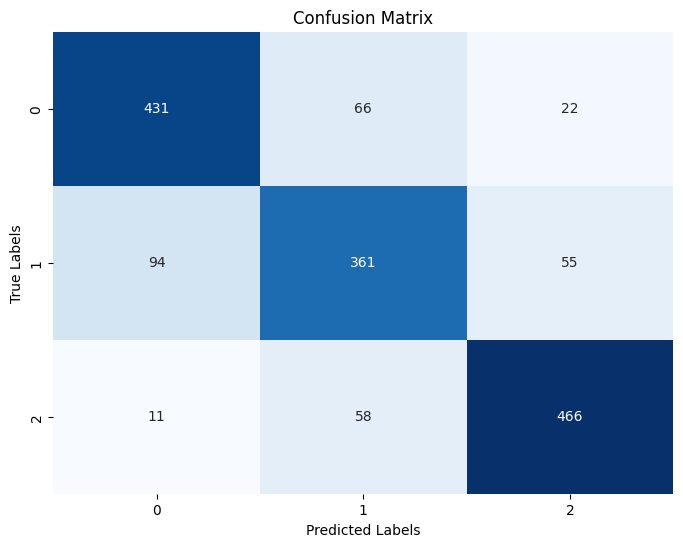


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       519
           1       0.74      0.71      0.73       510
           2       0.86      0.87      0.86       535

    accuracy                           0.80      1564
   macro avg       0.80      0.80      0.80      1564
weighted avg       0.80      0.80      0.80      1564


F1 Score: 0.8034955703532141
Recall: 0.8043478260869565
Accuracy: 0.8043478260869565


In [ ]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
accuracy = accuracy_score(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the results
print("\nClassification Report:")
print(class_report)

print("\nF1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)


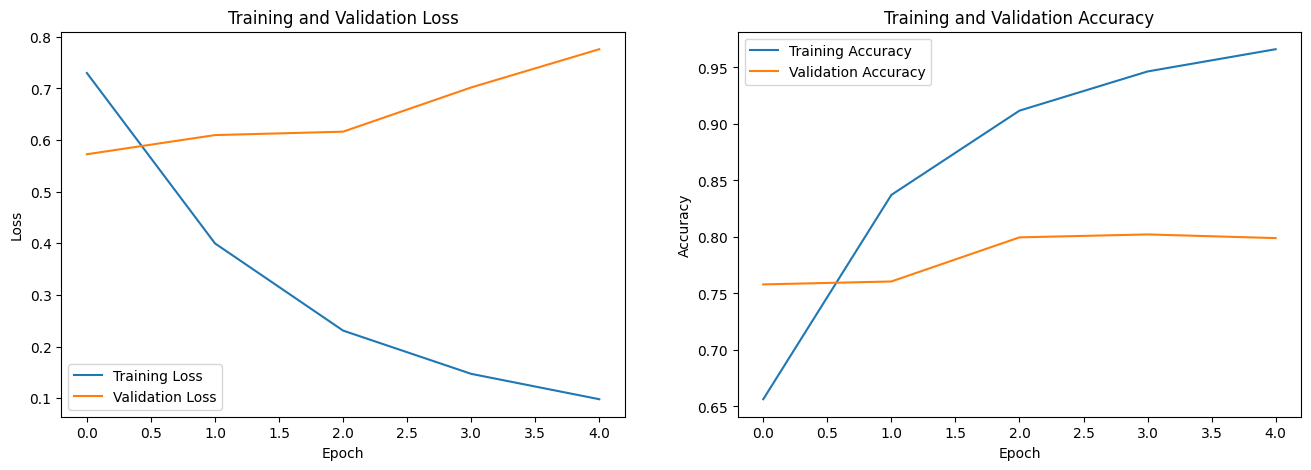

In [ ]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(train_loss, label='Training Loss')
axes[0].plot(val_loss, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_accuracy, label='Training Accuracy')
axes[1].plot(val_accuracy, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()


## 2-1-3. Freezing the 9 layers of model

• Freeze the first 9 layers of the model as mentioned in the article.

• Freezing all layers except the last layer and the embedding layer in the model

#### 2-1-3-1. Freeze first 9 layers

In [ ]:
from transformers import AutoModel

model_name = 'HooshvareLab/bert-base-parsbert-uncased'
model = AutoModel.from_pretrained(model_name)

num_layers = model.config.num_hidden_layers
print(f"Number of hidden layers in the {model_name} BERT model: {num_layers}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Number of hidden layers in the HooshvareLab/bert-base-parsbert-uncased BERT model: 12


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
label_map = {'e': 0, 'c': 1, 'n': 2}
train_data['label'] = cleaned_train_data['label'].map(label_map)
val_data['label'] = cleaned_val_data['label'].map(label_map)
test_data['label'] = cleaned_test_data['label'].map(label_map)

train_encodings = tokenizer(list(train_data['premise']), list(train_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
val_encodings = tokenizer(list(val_data['premise']), list(val_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
test_encodings = tokenizer(list(test_data['premise']), list(test_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {k: train_encodings[k] for k in train_encodings},
    train_data['label']
)).shuffle(len(train_data)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {k: val_encodings[k] for k in val_encodings},
    val_data['label']
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {k: test_encodings[k] for k in test_encodings},
    test_data['label']
)).batch(32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model configuration

In [ ]:
from transformers import TFBertForSequenceClassification

model2 = TFBertForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)
bert_layer = model2.get_layer('bert')
# freeze
num_layers_to_freeze = 9
for i in range(num_layers_to_freeze):
    bert_layer.encoder.layer[i].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size=9
)

Epoch 1/5
228/228 [==============================] - 224s 888ms/step - loss: 0.8506 - accuracy: 0.5751 - val_loss: 0.7057 - val_accuracy: 0.6630
Epoch 2/5
228/228 [==============================] - 199s 875ms/step - loss: 0.5367 - accuracy: 0.7710 - val_loss: 0.5801 - val_accuracy: 0.7606
Epoch 3/5
228/228 [==============================] - 199s 873ms/step - loss: 0.3203 - accuracy: 0.8713 - val_loss: 0.5904 - val_accuracy: 0.7840
Epoch 4/5
228/228 [==============================] - 203s 890ms/step - loss: 0.2021 - accuracy: 0.9255 - val_loss: 0.6090 - val_accuracy: 0.7892
Epoch 5/5
228/228 [==============================] - 199s 875ms/step - loss: 0.1176 - accuracy: 0.9575 - val_loss: 0.7215 - val_accuracy: 0.7794


In [ ]:
test_predictions = []
test_labels = []

for input_ids, labels in test_dataset:
    outputs = model2(input_ids=input_ids)
    logits = outputs.logits
    predicted = np.argmax(logits, axis=1)

    test_predictions.extend(predicted)
    test_labels.extend(labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

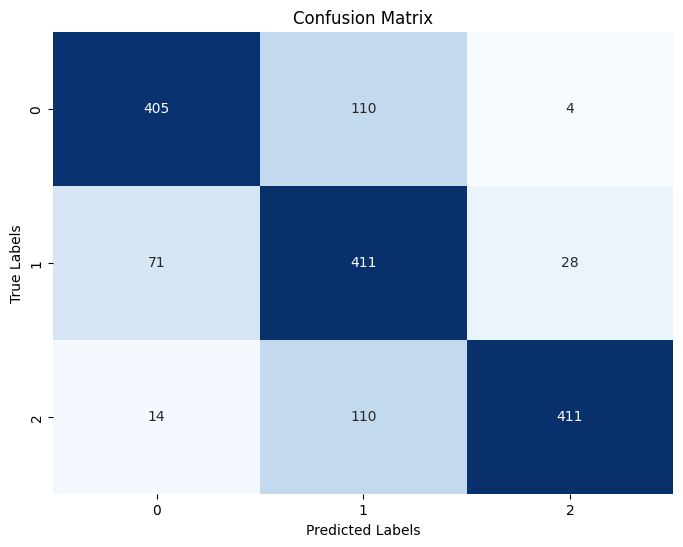


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       519
           1       0.65      0.81      0.72       510
           2       0.93      0.77      0.84       535

    accuracy                           0.78      1564
   macro avg       0.80      0.78      0.79      1564
weighted avg       0.80      0.78      0.79      1564


F1 Score: 0.7888218434705407
Recall: 0.7845268542199488
Accuracy: 0.7845268542199488


In [ ]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
accuracy = accuracy_score(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the results
print("\nClassification Report:")
print(class_report)

print("\nF1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)


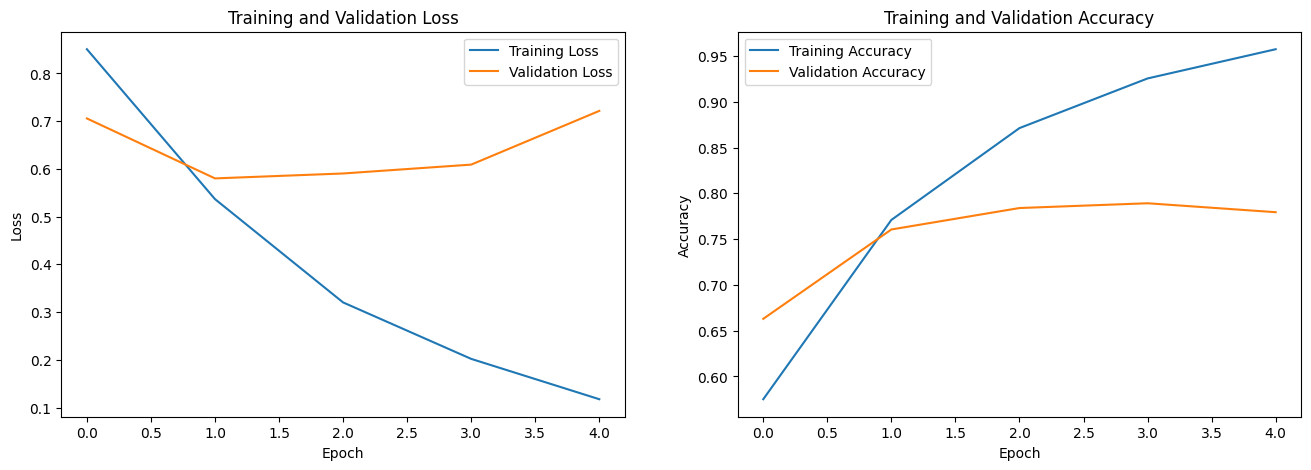

In [ ]:

train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(train_loss, label='Training Loss')
axes[0].plot(val_loss, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_accuracy, label='Training Accuracy')
axes[1].plot(val_accuracy, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()


#### 2-1-3-2. Freeze first all layers except last and embedding

In [ ]:
train_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Train-word.csv', sep='\t')
val_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Val-word.csv', sep='\t')
test_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Test-word.csv', sep='\t')

cleaned_train_data = clean_dataframe(train_data, [premise_column, hypothesis_column])
cleaned_val_data = clean_dataframe(val_data, [premise_column, hypothesis_column])
cleaned_test_data = clean_dataframe(test_data, [premise_column, hypothesis_column])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
label_map = {'e': 0, 'c': 1, 'n': 2}
train_data['label'] = cleaned_train_data['label'].map(label_map)
val_data['label'] = cleaned_val_data['label'].map(label_map)
test_data['label'] = cleaned_test_data['label'].map(label_map)

train_encodings = tokenizer(list(train_data['premise']), list(train_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
val_encodings = tokenizer(list(val_data['premise']), list(val_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')
test_encodings = tokenizer(list(test_data['premise']), list(test_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    {k: train_encodings[k] for k in train_encodings},
    train_data['label']
)).shuffle(len(train_data)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {k: val_encodings[k] for k in val_encodings},
    val_data['label']
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {k: test_encodings[k] for k in test_encodings},
    test_data['label']
)).batch(32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model configuration

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model3 = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

bert_layer = model3.get_layer('bert')

# Freeze all layers except the last layer and the embedding layer
last_layer_index = len(bert_layer.encoder.layer) - 1
for i, layer in enumerate(bert_layer.encoder.layer):
    if i != last_layer_index and 'embeddings' not in layer.name:
        layer.trainable = False



optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model3.compile(optimizer=optimizer, loss=loss, metrics=[metric])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size=9
)

Epoch 1/5
228/228 [==============================] - 247s 985ms/step - loss: 0.9233 - accuracy: 0.5337 - val_loss: 0.7569 - val_accuracy: 0.6207
Epoch 2/5
228/228 [==============================] - 192s 841ms/step - loss: 0.6816 - accuracy: 0.6795 - val_loss: 0.7406 - val_accuracy: 0.6493
Epoch 3/5
228/228 [==============================] - 191s 840ms/step - loss: 0.4880 - accuracy: 0.7759 - val_loss: 0.7015 - val_accuracy: 0.7183
Epoch 4/5
228/228 [==============================] - 192s 841ms/step - loss: 0.3307 - accuracy: 0.8628 - val_loss: 0.7221 - val_accuracy: 0.7404
Epoch 5/5
228/228 [==============================] - 192s 841ms/step - loss: 0.2320 - accuracy: 0.9092 - val_loss: 0.8321 - val_accuracy: 0.7300


In [ ]:
test_predictions = []
test_labels = []

for input_ids, labels in test_dataset:
    outputs = model3(input_ids=input_ids)
    logits = outputs.logits
    predicted = np.argmax(logits, axis=1)

    test_predictions.extend(predicted)
    test_labels.extend(labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

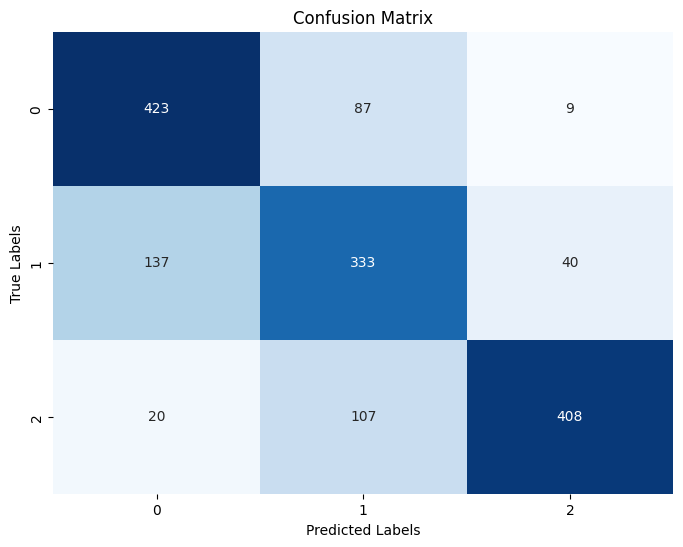


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       519
           1       0.63      0.65      0.64       510
           2       0.89      0.76      0.82       535

    accuracy                           0.74      1564
   macro avg       0.75      0.74      0.74      1564
weighted avg       0.75      0.74      0.75      1564


F1 Score: 0.7462551226620019
Recall: 0.7442455242966752
Accuracy: 0.7442455242966752


In [ ]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
accuracy = accuracy_score(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the results
print("\nClassification Report:")
print(class_report)

print("\nF1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)


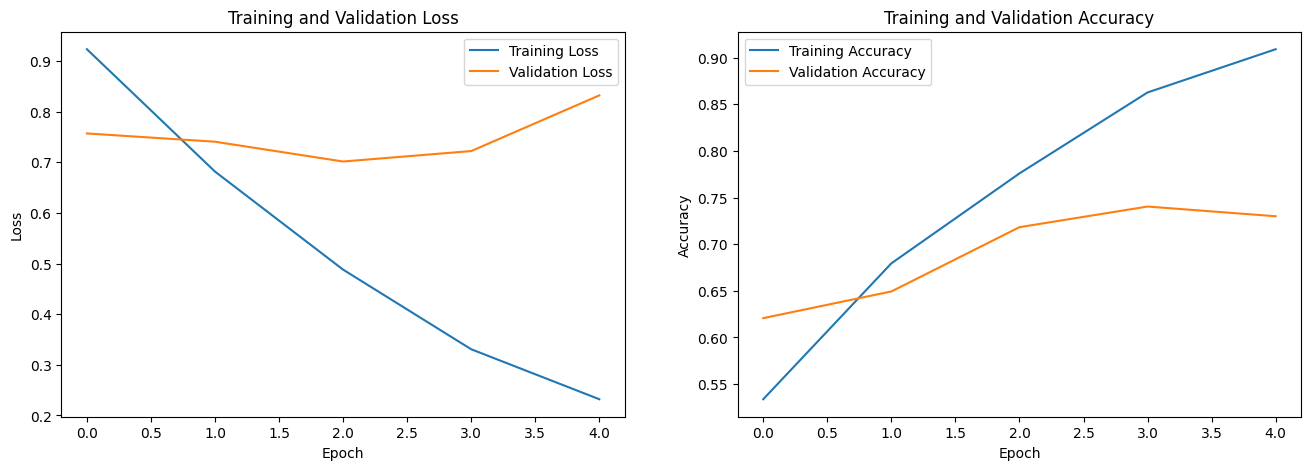

In [ ]:

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(train_loss, label='Training Loss')
axes[0].plot(val_loss, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_accuracy, label='Training Accuracy')
axes[1].plot(val_accuracy, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()


## 2-1-4. Fine Tunning on the Middle Layers

In [4]:
train_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Train-word.csv', sep='\t')
val_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Val-word.csv', sep='\t')
test_data = pd.read_csv('/content/FarsTail_dataset/FarsTail-master/data/Test-word.csv', sep='\t')

# cleaned_train_data = clean_dataframe(train_data, [premise_column, hypothesis_column])
# cleaned_val_data = clean_dataframe(val_data, [premise_column, hypothesis_column])
# cleaned_test_data = clean_dataframe(test_data, [premise_column, hypothesis_column])

below code creates pytorch dataset

In [5]:
import torch
from transformers import AutoTokenizer

# Load and tokenize data
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Convert labels to numerical format
label_map = {'e': 0, 'c': 1, 'n': 2}
train_data['label'] = train_data['label'].map(label_map).astype('int64')  # PyTorch uses int64 for labels
val_data['label'] = val_data['label'].map(label_map).astype('int64')
test_data['label'] = test_data['label'].map(label_map).astype('int64')

# Rest of the code remains the same as mentioned in the previous steps for tokenization and dataset creation

# Tokenize data
train_encodings = tokenizer(list(train_data['premise']), list(train_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='pt')
val_encodings = tokenizer(list(val_data['premise']), list(val_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='pt')
test_encodings = tokenizer(list(test_data['premise']), list(test_data['hypothesis']), truncation=True, padding='max_length', max_length=160, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:

# Create PyTorch datasets
class CustomDataset(torch.utils.data.Dataset):
      def __init__(self, encodings, labels):
          self.encodings = encodings
          self.labels = labels

      def __getitem__(self, idx):
          item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
          item['labels'] = torch.tensor(self.labels[idx])
          return item

      def __len__(self):
          return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_data['label'])
val_dataset = CustomDataset(val_encodings, val_data['label'])
test_dataset = CustomDataset(test_encodings, test_data['label'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12)

delete layers after 9 layers and creating a custom bert.

In [13]:
from transformers import BertModel

# Load the entire pre-trained BERT model
full_bert_model = BertModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Get the individual layers from the BERT model
bert_layers = list(full_bert_model.children())

# Select the first nine layers
first_nine_layers = bert_layers[:9]

class CustomBERTModel(torch.nn.Module):
    def __init__(self, first_nine_layers, hidden_size, output_classes):
        super(CustomBERTModel, self).__init__()
        self.first_nine_layers = torch.nn.ModuleList(first_nine_layers)
        self.classifier = torch.nn.Linear(hidden_size, output_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        output = input_ids
        attentions = []

        for i, layer in enumerate(self.first_nine_layers):
            if isinstance(output, BaseModelOutputWithPastAndCrossAttentions):
                output = output.last_hidden_state  # Assuming you want the last hidden state

            if isinstance(layer, torch.nn.modules.activation.MultiheadAttention):
                output, attention = layer(output, attn_mask=attention_mask)
                attentions.append(attention)
            else:
                output = layer(output.clone().detach() if isinstance(output, torch.Tensor) else output)

        logits = self.classifier(output)  # Consider using the entire sequence representation directly

        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))  # Reshape logits and labels for loss calculation
            return loss
        else:
            return logits, attentions


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [ ]:
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
import torch

hidden_size = 768
output_classes = 3

model4 = CustomBERTModel(first_nine_layers, hidden_size, output_classes)



optimizer = optim.Adam(model4.parameters(), lr=9e-5)  # lr is the learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.to(device)


In [15]:
import torch
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model4.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items()}
        labels = inputs.pop('labels')

        outputs = model4(**inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Extracting the appropriate output tensor
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model4.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            labels = inputs.pop('labels')

            outputs = model4(**inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Extracting the appropriate output tensor
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")



<ipython-input-12-9c58ff6240d5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch [1/5] - Train Loss: 1.0506 | Val Loss: 0.9868 | Train Acc: 0.4370 | Val Acc: 0.4873
Epoch [2/5] - Train Loss: 1.0044 | Val Loss: 0.9815 | Train Acc: 0.4879 | Val Acc: 0.4951
Epoch [3/5] - Train Loss: 0.9826 | Val Loss: 0.9243 | Train Acc: 0.5017 | Val Acc: 0.5465
Epoch [4/5] - Train Loss: 0.9732 | Val Loss: 0.9103 | Train Acc: 0.5091 | Val Acc: 0.5615
Epoch [5/5] - Train Loss: 0.9656 | Val Loss: 0.9055 | Train Acc: 0.5168 | Val Acc: 0.5563


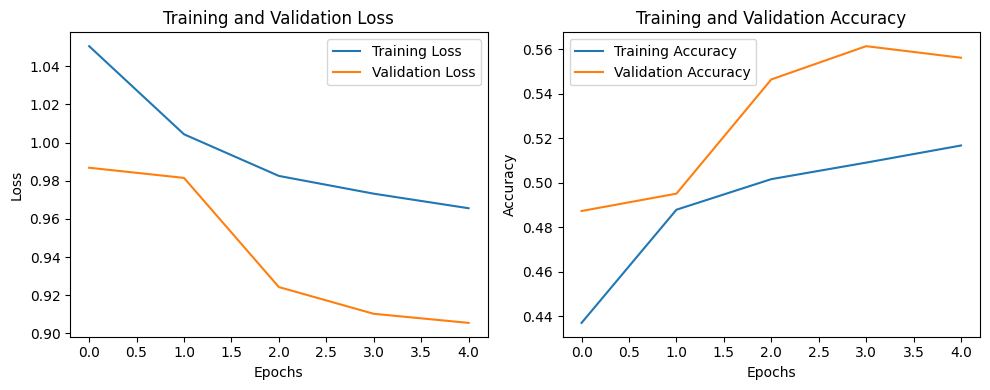

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-12-9c58ff6240d5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


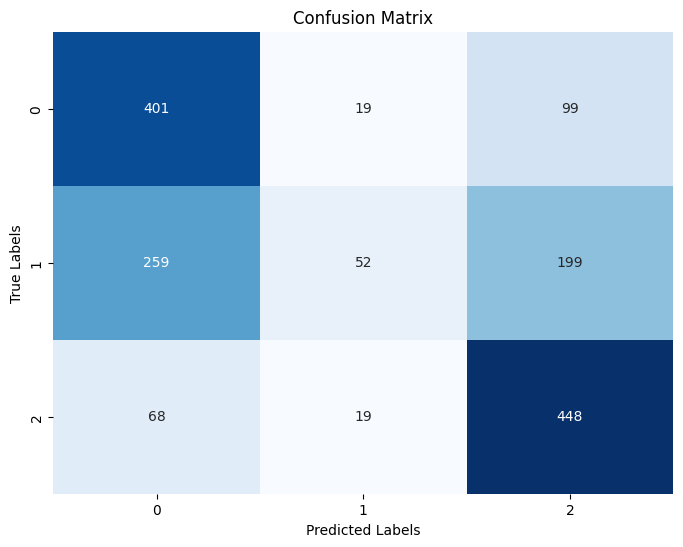


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       519
           1       0.58      0.10      0.17       510
           2       0.60      0.84      0.70       535

    accuracy                           0.58      1564
   macro avg       0.58      0.57      0.51      1564
weighted avg       0.58      0.58      0.51      1564


F1 Score: 0.5092066175653848
Recall: 0.5760869565217391
Accuracy: 0.5760869565217391


In [18]:
model4.eval()

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        labels = inputs.pop('labels')

        outputs = model4(**inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
accuracy = accuracy_score(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nClassification Report:")
print(class_report)

print("\nF1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)